# Compare prediction

In [38]:
import sys
sys.path.insert(0,"/home/gridsan/hwpang/Software/RMG-Py/")
sys.path.insert(0,"..")

import json
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import string
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from tree.parameters import Ts
from tree.utils import linestyles, markers

In [39]:
hbi_unc_df = pd.read_csv("../data/hbi_unc.csv")

with open("../data/splits/random.json", "r") as f:
    train_inds, test_inds = json.load(f)

num_training = len(train_inds)

test_df = hbi_unc_df.loc[test_inds, :]
test_df = test_df.reset_index(drop=True)

# Load test results

In [48]:
sidt_df_dict = {}
fractions = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
run_dirs = {
    "../models/split-random_run-basecase": "BC",
    "../models/split-random_run-basecase-bounded": "BC_UB",
    "../models/split-random_run-aleatoric-prepruning-bounded": "AP_UB",
    "../models/split-random_run-model-variance-prepruning-0.05-bounded": "MP0.05_UB",
    "../models/split-random_run-model-variance-prepruning-0.005-bounded": "MP0.005_UB",
    "../models/split-random_run-model-variance-prepruning-0.001-bounded": "MP0.001_UB",
    "../models/split-random_run-model-variance-prepruning-0.0005-bounded": "MP0.0005_UB",
}
for run_dir in run_dirs:
    for frac in fractions:
        sidt_df = pd.read_csv(f"{run_dir}/frac-{frac}/test.csv")
        sidt_df_dict[run_dir, frac] = sidt_df

# Get tree size

In [49]:
tree_sizes = {}
for run_dir in run_dirs:
    for frac in fractions:
        tree_path = f"{run_dir}/frac-{frac}/tree.py"
        with open(tree_path, "r") as f:
            lines = f.readlines()
            tree_size = sum("index = " in line for line in lines)
            tree_sizes[run_dir, frac] = tree_size
            
# tree_sizes

# Get RMSE/MAE

In [50]:
temp_dict = {
    "fraction of training": [],
    "run_dir": [],
    "tree_size": [],
}

for column in test_df.columns:
    if column.startswith("HBI_"):
        temp_dict["rmse_"+column] = []
        temp_dict["mae_"+column] = []
        temp_dict["bounded_"+column] = []

for (run_dir, frac), sidt_df in sidt_df_dict.items():
    temp_dict["fraction of training"].append(frac)
    temp_dict["run_dir"].append(run_dir)
    temp_dict["tree_size"].append(tree_sizes[run_dir, frac])
    for column in test_df.columns:
        if column.startswith("HBI_"):
            true_ys = test_df[column]
            pred_ys = sidt_df[column]
            temp_dict["rmse_"+column].append(np.sqrt(mean_squared_error(true_ys, pred_ys)))
            temp_dict["mae_"+column].append(mean_absolute_error(true_ys, pred_ys))
            
            pred_unc = sidt_df["unc_"+column]
            true_err = (sidt_df[column] - test_df[column]).abs()
            data_unc = test_df["unc_"+column]
            temp_dict["bounded_"+column].append(sum((pred_unc >= true_err)) / len(pred_unc))

result_df = pd.DataFrame(temp_dict)
# result_df

# Plot: BC vs. BC_UB

## Bounded uncertainty vs. training fraction

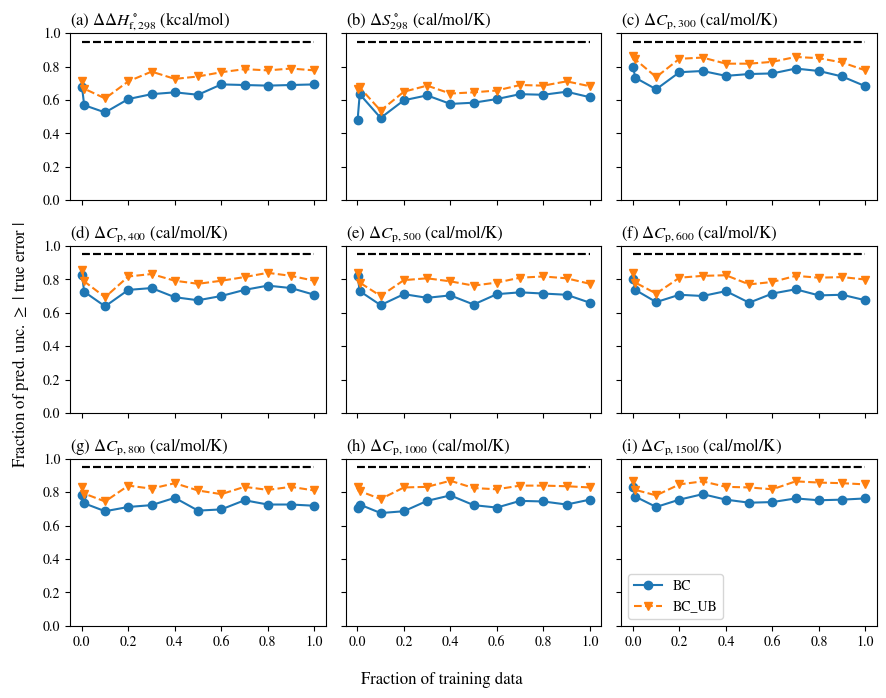

In [21]:
run_dirs_to_plot = ["BC", "BC_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharey=True, sharex=True, figsize=(9, 7))
bins = 20

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "bounded_HBI_H298 (kcal/mol)"
        ax.plot([0, 1], [0.95, 0.95], "k--")
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_ylim([0, 1])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "bounded_HBI_Sint298 (cal/mol/K)"
        ax.plot([0, 1], [0.95, 0.95], "k--")
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_ylim([0, 1])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"bounded_HBI_Cp{T} (cal/mol/K)"
            ax.plot([0, 1], [0.95, 0.95], "k--")
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_ylim([0, 1])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")
            
        counter+=1

axs.flat[-1].legend()
fig.supylabel("Fraction of pred. unc. $\geq$ | true error |")
fig.supxlabel("Fraction of training data")

fig.tight_layout()
fig.savefig("../figures/bounded_uncertainty_frac_vs_training_frac.pdf", bbox_inches="tight")

In [23]:
test_df

,radical_smiles,resonance_radical_smiles,resonance_radical_num_rotatable_bonds,radical_H298 (kcal/mol),radical_Sint298 (cal/mol/K),radical_source,radical_level_of_theory,radical_Cp300 (cal/mol/K),radical_Cp400 (cal/mol/K),radical_Cp500 (cal/mol/K),...,unc_closed_shell_Cp1500 (cal/mol/K),unc_HBI_H298 (kcal/mol),unc_HBI_Sint298 (cal/mol/K),unc_HBI_Cp300 (cal/mol/K),unc_HBI_Cp400 (cal/mol/K),unc_HBI_Cp500 (cal/mol/K),unc_HBI_Cp600 (cal/mol/K),unc_HBI_Cp800 (cal/mol/K),unc_HBI_Cp1000 (cal/mol/K),unc_HBI_Cp1500 (cal/mol/K)
0,[O]C(=O)OC(=O)O,[O]C(=O)OC(=O)O,0,-164.838453,87.670293,dong_pio_liang.py,CBS-QB3,23.387634,26.613081,29.284902,...,1.0,1.697056,1.414214,1.414214,1.414214,1.414214,1.414214,1.414214,1.414214,1.414214
1,CC(=O)COC(O[O])OC(C)=O,CC(=O)COC(O[O])OC(C)=O,7,-164.222931,134.520962,dong_pio_liang.py,CBS-QB3,51.800544,60.936453,68.795453,...,2.0,4.176123,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068
2,[O]OC(=O)OC(=O)O,[O]OC(=O)OC(=O)O,0,-155.105883,93.562651,dong_pio_liang.py,CBS-QB3,29.543449,33.217979,35.694866,...,1.0,1.697056,1.414214,1.414214,1.414214,1.414214,1.414214,1.414214,1.414214,1.414214
3,C[C]1OC(=O)C(O)(C=O)O1,C[C]1OC(=O)C(O)(C=O)O1,3,-151.205886,98.996040,dong_pio_liang.py,CBS-QB3,38.751751,46.650997,52.369635,...,2.0,4.176123,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068
4,CC1(OO)COC(O[O])C(=O)O1,CC1(OO)COC(O[O])C(=O)O1,4,-137.513199,113.097378,dong_pio_liang.py,CBS-QB3,46.328845,56.831030,65.250112,...,2.0,4.176123,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,C#CC1([CH2])OO1,C#CC1([CH2])OO1,1,96.427971,79.485861,dong_pio_liang.py,CBS-QB3,24.423412,29.090718,32.193888,...,2.0,4.176123,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068
270,C#CCC=[C]C,C#CCC=[C]C,2,116.422647,89.067407,dong_pio_liang.py,CBS-QB3,26.955486,32.081066,36.841331,...,2.0,4.176123,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068
271,CC=C=C1[CH]C1,CC=C=C1[CH]C1,1,119.785415,85.628683,dong_pio_liang.py,CBS-QB3,26.996656,32.629649,37.664892,...,2.0,4.176123,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068
272,CC=C=C1[CH]C1,CC=[C]C1=CC1,2,119.785415,85.628683,dong_pio_liang.py,CBS-QB3,26.996656,32.629649,37.664892,...,1.0,1.697056,1.414214,1.414214,1.414214,1.414214,1.414214,1.414214,1.414214,1.414214


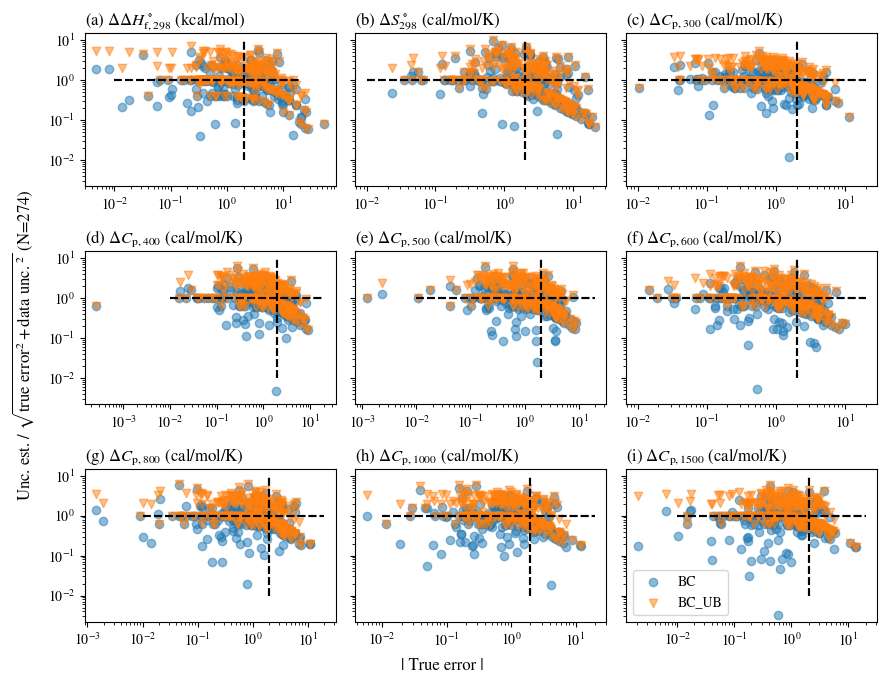

In [36]:
run_dirs_to_plot = ["BC","BC_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9, 7), sharey=True)

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        
        sidt_df = sidt_df_dict[run_dir, 1.0]
        
        ax = axs.flat[0]
        label = "HBI_H298 (kcal/mol)"
        true_ys = test_df[label].values
        data_uncs = test_df["unc_"+label].values
        pred_ys = sidt_df[label].values
        pred_uncs = sidt_df["unc_"+label].values
        true_errs = np.abs(pred_ys - true_ys)
        ax.scatter(true_errs, pred_uncs / np.sqrt(true_errs**2 + data_uncs**2), label=run_dirs[run_dir], marker=markers[counter], alpha=0.5)
        ax.hlines(y=1, xmin=1e-2, xmax=2e1, linestyle="--", color="k")
        ax.vlines(x=2, ymin=1e-2, ymax=1e1, linestyle="--", color="k")
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "HBI_Sint298 (cal/mol/K)"
        true_ys = test_df[label].values
        data_uncs = test_df["unc_"+label].values
        pred_ys = sidt_df[label].values
        pred_uncs = sidt_df["unc_"+label].values
        true_errs = np.abs(pred_ys - true_ys)
        ax.scatter(true_errs, pred_uncs / np.sqrt(true_errs**2 + data_uncs**2), label=run_dirs[run_dir], marker=markers[counter], alpha=0.5)
        ax.hlines(y=1, xmin=1e-2, xmax=2e1, linestyle="--", color="k")
        ax.vlines(x=2, ymin=1e-2, ymax=1e1, linestyle="--", color="k")
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"HBI_Cp{T} (cal/mol/K)"
            true_ys = test_df[label].values
            data_uncs = test_df["unc_"+label].values
            pred_ys = sidt_df[label].values
            pred_uncs = sidt_df["unc_"+label].values
            true_errs = np.abs(pred_ys - true_ys)
            ax.scatter(true_errs, pred_uncs / np.sqrt(true_errs**2 + data_uncs**2), label=run_dirs[run_dir], marker=markers[counter], alpha=0.5)
            ax.hlines(y=1, xmin=1e-2, xmax=2e1, linestyle="--", color="k")
            ax.vlines(x=2, ymin=1e-2, ymax=1e1, linestyle="--", color="k")
            ax.set_yscale("log")
            ax.set_xscale("log")
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")
            
        counter += 1

axs.flat[-1].legend()
fig.supylabel("Unc. est. / $\sqrt{ \mathrm{true\,\,error}^2 + \mathrm{data\,\,unc.}^2 }$ "+f"(N={len(test_df.index)})")
fig.supxlabel(f"| True error |", y=0.03)
fig.tight_layout()

# fig.savefig("../figures/sidt_unc_div_true_error_vs_true_error_BC_vs_BC_UB.pdf", bbox_inches="tight")

# Plot: BC_UB vs. AP_UB

## RMSE/MAE vs. tree size

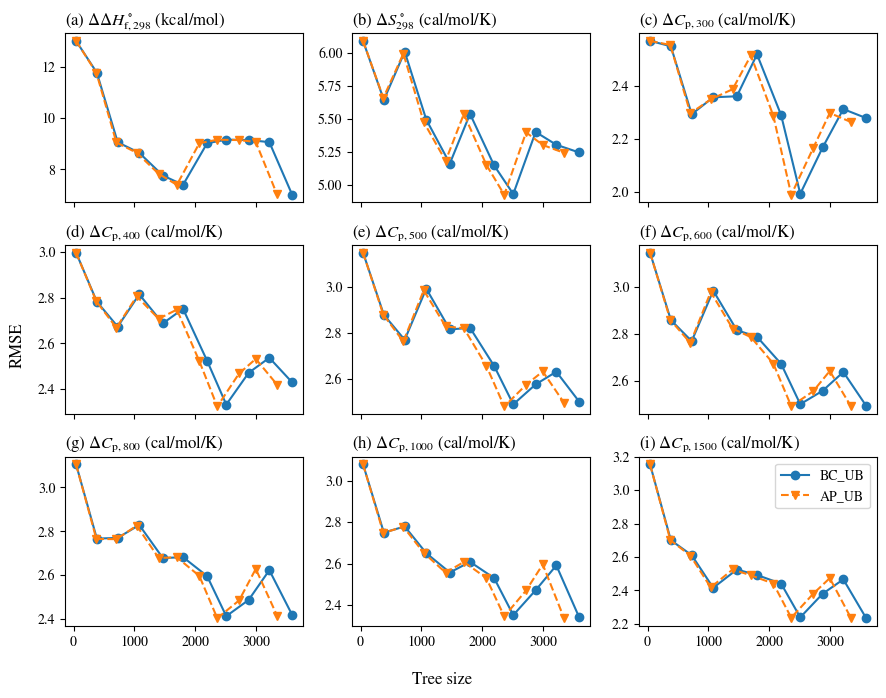

In [51]:
run_dirs_to_plot = ["BC_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "rmse_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "rmse_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"rmse_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"RMSE")
fig.supxlabel(f"Tree size")

fig.tight_layout()
fig.savefig("../figures/rmse_vs_tree_size_BC_vs_AP.pdf", bbox_inches="tight")

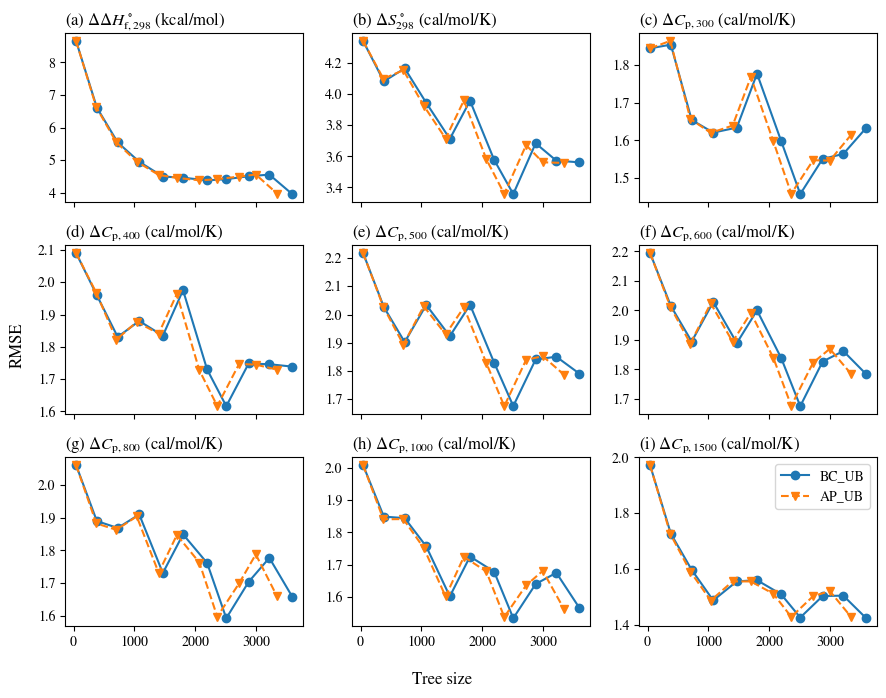

In [52]:
run_dirs_to_plot = ["BC_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "mae_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "mae_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"mae_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"RMSE")
fig.supxlabel(f"Tree size")

fig.tight_layout()
fig.savefig("../figures/mae_vs_tree_size_BC_vs_AP.pdf", bbox_inches="tight")

## RMSE/MAE vs. training fraction

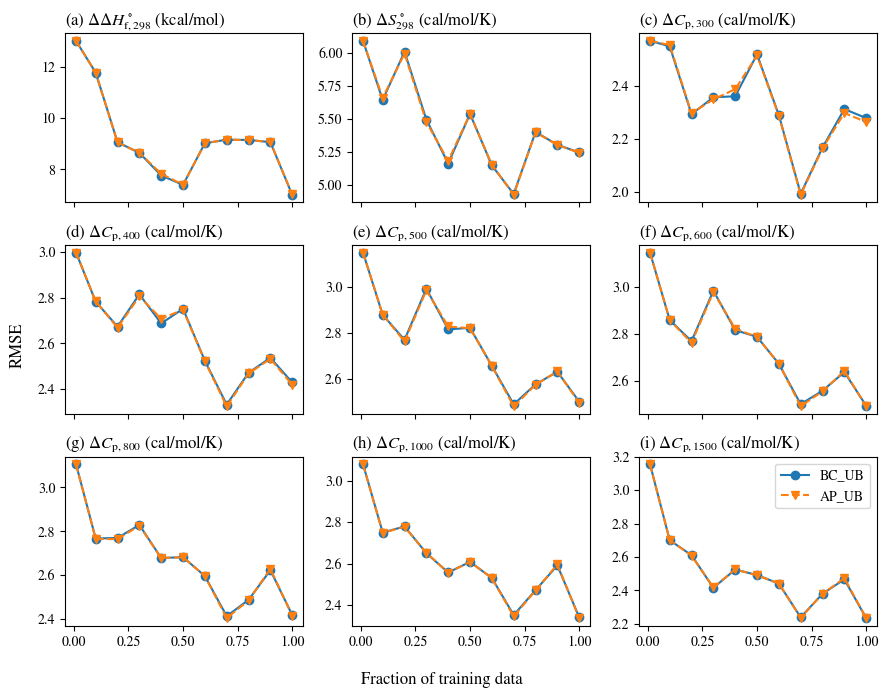

In [53]:
run_dirs_to_plot = ["BC_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "rmse_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "rmse_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"rmse_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"RMSE")
fig.supxlabel(f"Fraction of training data")

fig.tight_layout()
fig.savefig("../figures/rmse_vs_training_frac_BC_vs_AP.pdf", bbox_inches="tight")

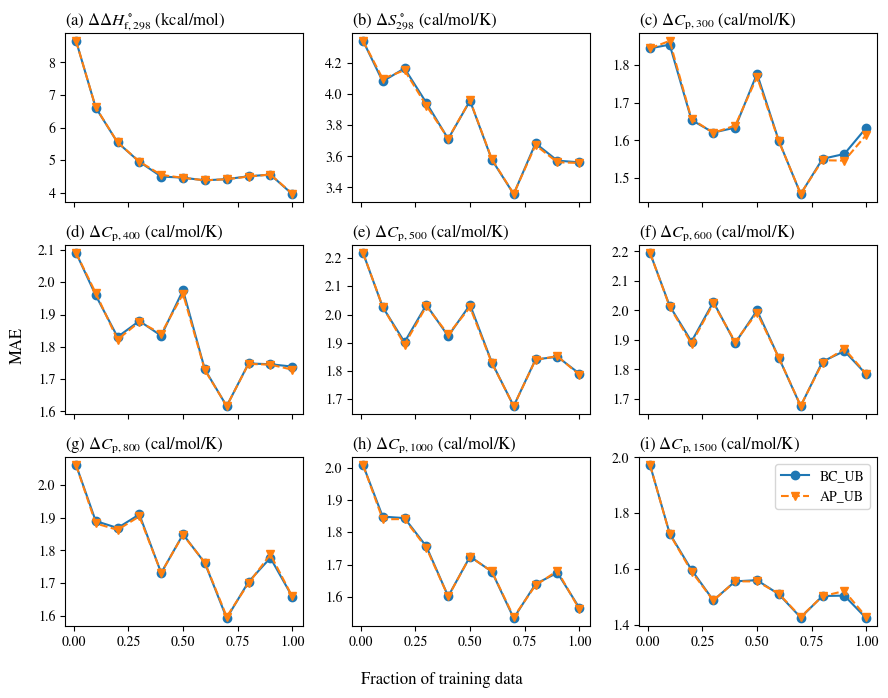

In [54]:
run_dirs_to_plot = ["BC_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "mae_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "mae_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"mae_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"MAE")
fig.supxlabel(f"Fraction of training data")

fig.tight_layout()
fig.savefig("../figures/mae_vs_training_frac_BC_vs_AP.pdf", bbox_inches="tight")

# MP vs. AP

## RMSE/MAE vs. tree size

In [ ]:
run_dirs_to_plot = ["MP0.05_UB", "MP0.005_UB", "MP0.001_UB", "MP0.0005_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "rmse_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "rmse_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"rmse_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"RMSE")
fig.supxlabel(f"Tree size")

fig.tight_layout()
fig.savefig("../figures/rmse_vs_tree_size_AP_vs_MP.pdf", bbox_inches="tight")

In [ ]:
run_dirs_to_plot = ["MP0.05_UB", "MP0.005_UB", "MP0.001_UB", "MP0.0005_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "mae_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "mae_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"mae_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"MAE")
fig.supxlabel(f"Tree size")

fig.tight_layout()
fig.savefig("../figures/mae_vs_tree_size_AP_vs_MP.pdf", bbox_inches="tight")

## RMSE/MAE vs. training fraction

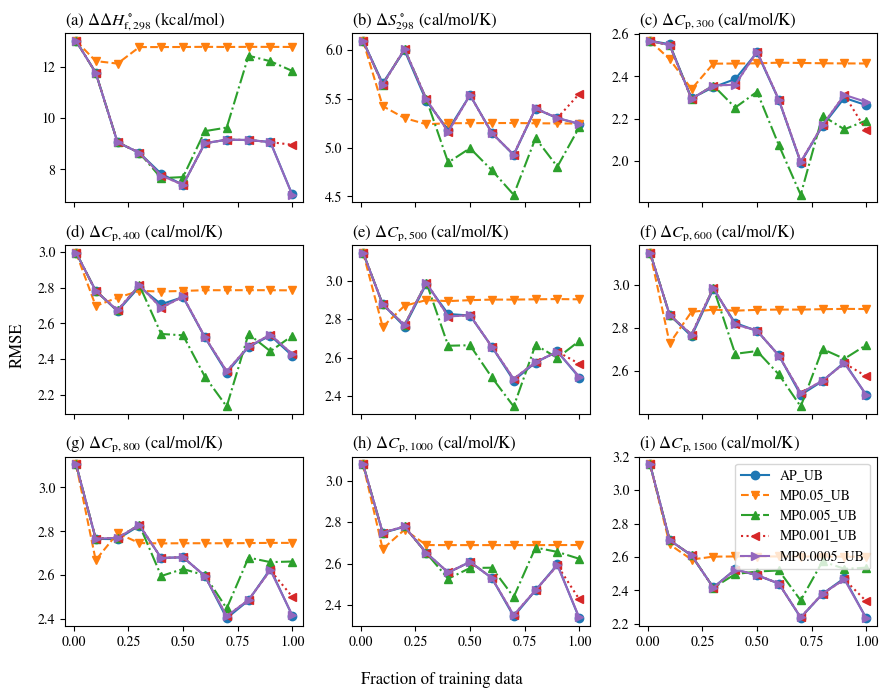

In [57]:
run_dirs_to_plot = ["MP0.05_UB", "MP0.005_UB", "MP0.001_UB", "MP0.0005_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "rmse_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "rmse_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"rmse_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"RMSE")
fig.supxlabel(f"Fraction of training data")

fig.tight_layout()
fig.savefig("../figures/rmse_vs_training_frac_AP_vs_MP.pdf", bbox_inches="tight")

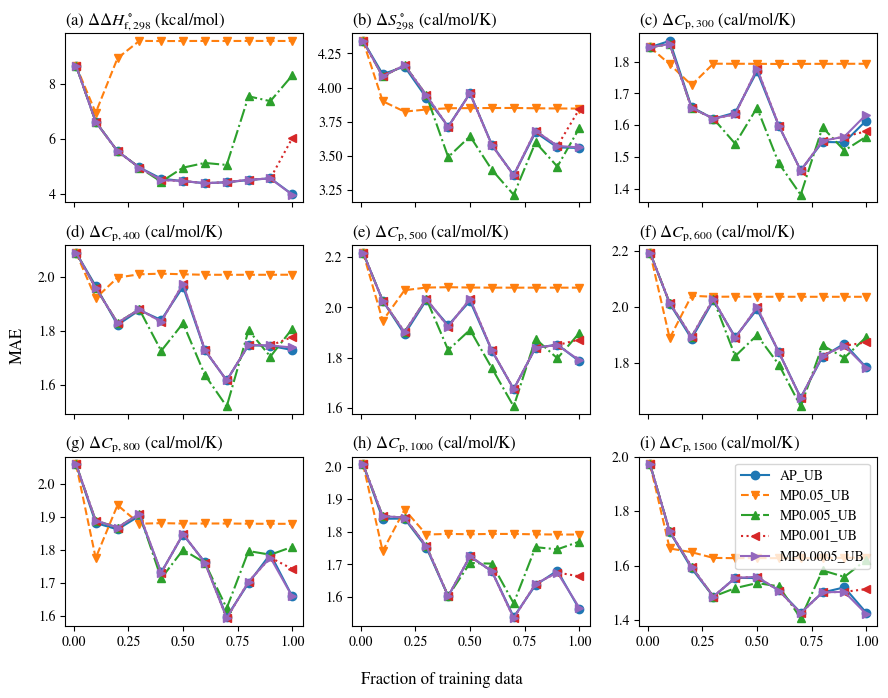

In [58]:
run_dirs_to_plot = ["MP0.05_UB", "MP0.005_UB", "MP0.001_UB", "MP0.0005_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "mae_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "mae_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"mae_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"MAE")
fig.supxlabel(f"Fraction of training data")

fig.tight_layout()
fig.savefig("../figures/mae_vs_training_frac_AP_vs_MP.pdf", bbox_inches="tight")

# Other

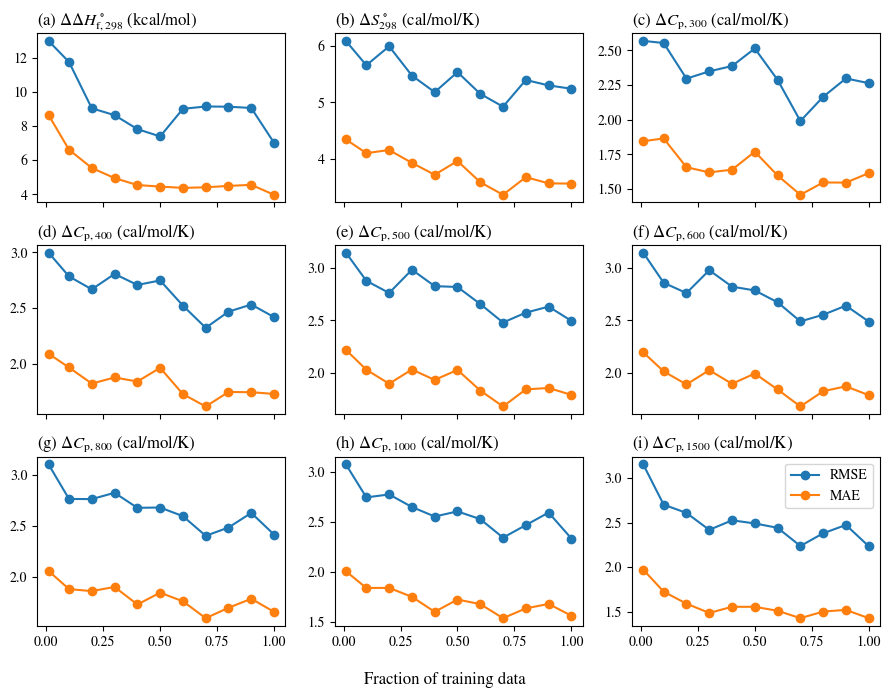

In [61]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))
bins = 20

run_dir = "../models/split-random_run-aleatoric-prepruning-bounded"

ax = axs.flat[0]
label = "HBI_H298 (kcal/mol)"
ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, "rmse_"+label], "-o")
ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, "mae_"+label], "-o")
ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

ax = axs.flat[1]
label = "HBI_Sint298 (cal/mol/K)"
ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, "rmse_"+label], "-o")
ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, "mae_"+label], "-o")
ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
    label = f"HBI_Cp{T} (cal/mol/K)"
    ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, "rmse_"+label], "-o", label="RMSE")
    ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, "mae_"+label], "-o", label="MAE")
    ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

axs.flat[-1].legend()
fig.supxlabel(f"Fraction of training data")

fig.tight_layout()
# fig.savefig("../figures/rmse_mae_vs_training_frac.pdf", bbox_inches="tight")